# EM algorithm test 2

In [23]:
import sys
sys.path.append('../src/')

from simulate_gillespie import gillespie_linear, discretize_sequence

In [ ]:
import matplotlib.pyplot as plt
import birdepy as bd
import numpy as np

# Simple linear BDP

In [40]:
## --- Setup --- ##
test_name = "linear_BDP_test"

N = 100
I0 = 5

time_max = 50.0

# linear BDP rates, $: R_0 > 1
beta = 0.8 # birth rate
mu = 0.55   # death rate


theta_true = (beta, mu)

print(f"Setup for {test_name}")
print(f"N = {N}, I0 = {I0}, time_max = {time_max:.1f}")
print(f"beta = {beta}, mu = {mu}")
print(f"R_0 = {beta / mu:.2f}")

Setup for linear_BDP_test
N = 100, I0 = 5, time_max = 50.0
beta = 0.8, mu = 0.55
R_0 = 1.45


In [41]:
# generate continuously observed data
# discretize it
# plot both

# choose 25 intervals that is 26 observation points
# with dt = (25 - 0)/25 = 1
t_obs_start = 0.0
t_obs_end = 25.0
num_intervals = 25

X_times, X_states = gillespie_linear(N, theta_true, I0, time_max)
len(X_times) # number of events

break: time >= time_max


4583

In [42]:
Y_obs_sequence = discretize_sequence((X_times, X_states), t_obs_start, t_obs_end, num_intervals)
Y_obs_sequence[:5]

[(5, 4, np.float64(1.0)),
 (4, 6, np.float64(1.0)),
 (6, 11, np.float64(1.0)),
 (11, 14, np.float64(1.0)),
 (14, 16, np.float64(1.0))]

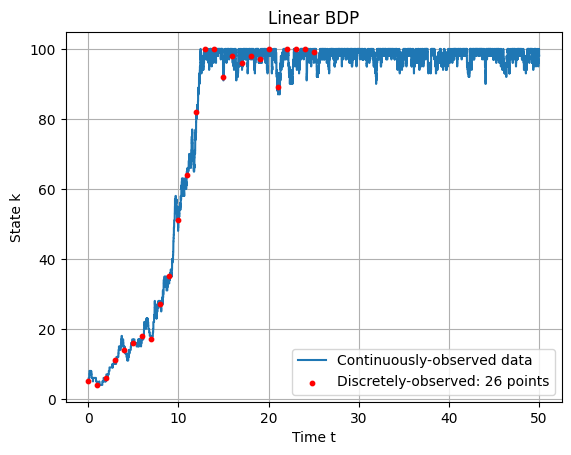

In [43]:
# plot data
plt.figure()

plt.step(X_times, X_states, where='post', 
         label='Continuously-observed data')

observation_times = np.linspace(t_obs_start, t_obs_end, num_intervals + 1)

# state at t_obs_start
observed_states_at_times = [Y_obs_sequence[0][0]]

# states at t_obs_start + dt, + 2dt, ..., t_obs_end
observed_states_at_times.extend([interval[1] for interval in Y_obs_sequence])

plt.scatter(observation_times, observed_states_at_times,
            color='red', marker='o', s=10, zorder=2,
            label=f'Discretely-observed: {num_intervals + 1} points')

plt.title("Linear BDP")
plt.xlabel("Time t")
plt.ylabel("State k")

plt.legend()
plt.grid(True)
plt.show()

## Estimate

In [52]:
dt = Y_obs_sequence[0][2] # step size, interval duration
observed_times = np.linspace(t_obs_start, t_obs_end + num_intervals * dt, num_intervals + 1)

observed_states = [Y_obs_sequence[0][0]]
observed_states

[5]

In [53]:
observed_states.extend([interval[1] for interval in Y_obs_sequence])
observed_states[:5]

[5, 4, 6, 11, 14]

In [56]:
t_data_input = list(observed_times)
p_data_input = list(observed_states)

# set bounds (0, 5]
p_bounds = [[1e-9, 5.0], [1e-9, 5.0]]

In [57]:
p0_guess = [0.6, 0.6]
# run EM until 
# |\theta^{(k + 1)} - \theta^{(k)}| < tol 
# or max_iter is reached
est_em_ilt = bd.estimate(
    t_data=t_data_input,
    p_data=p_data_input,
    p0=p0_guess,
    p_bounds=p_bounds,
    framework='em',
    model='linear',
    technique='ilt',
    accelerator='Lange', # let's use Lange acceleration
    max_it=100, # max iter
    i_tol=1e-6, # tol
    # laplace_method='cme-talbot', # Default ILT method
    # lentz_eps=1e-6, # Lentz algorithm tolerance
    se_type='asymptotic', # std errors using Hessian
    display=True # show progress
)

/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:435: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  fx = wrapped_fun(x)
/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/scipy/optimize/_slsqp_py.py:439: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  g = append(wrapped_grad(x), 0.0)


Iteration  1  estimate is:  [9.99999972e-10 5.00000000e+00]


/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/birdepy/utility.py:82: SyntaxWarning: invalid escape sequence '\%'
  labels = ["$50\%$", "$80\%$", "$95\%$"]
/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/birdepy/utility.py:82: SyntaxWarning: invalid escape sequence '\%'
  labels = ["$50\%$", "$80\%$", "$95\%$"]
/Users/markolalovic/dev/higher-order-contagion/.venv/lib/python3.13/site-packages/birdepy/utility.py:82: SyntaxWarning: invalid escape sequence '\%'
  labels = ["$50\%$", "$80\%$", "$95\%$"]


ValueError: `x0` violates bound constraints.

In [ ]:
# 25 intervals, means 25 sets of E-step calculations
# E[U | Y], E[D | Y], E[T_part | Y] for each (a, b, dt) in Y

# accelerator='none'

# could switch to matrix exponential technique='expm'
